### Library

Link paper: https://www.sciencedirect.com/science/article/pii/S1361841519300799 

In [ ]:
import skimage.color
import numpy as np
import random
from PIL import Image, ImageEnhance, ImageOps
import math
from scipy import linalg
from skimage.util import dtype, dtype_limits
from skimage.exposure import rescale_intensity
import time

rgb_from_hed = np.array([[0.65, 0.70, 0.29],
                         [0.07, 0.99, 0.11],
                         [0.27, 0.57, 0.78]]).astype('float32')
hed_from_rgb = linalg.inv(rgb_from_hed).astype('float32')


def rgb2hed(rgb):

    return separate_stains(rgb, hed_from_rgb)

def hed2rgb(hed):

    return combine_stains(hed, rgb_from_hed)

def separate_stains(rgb, conv_matrix):

  

    rgb = dtype.img_as_float(rgb, force_copy=True).astype('float32')
    rgb += 2
    stains = np.dot(np.reshape(-np.log(rgb), (-1, 3)), conv_matrix)
    return np.reshape(stains, rgb.shape)


def combine_stains(stains, conv_matrix):



    stains = dtype.img_as_float(stains.astype('float64')).astype('float32')  # stains are out of range [-1, 1] so dtype.img_as_float complains if not float64
    logrgb2 = np.dot(-np.reshape(stains, (-1, 3)), conv_matrix)
    rgb2 = np.exp(logrgb2)
    return rescale_intensity(np.reshape(rgb2 - 2, stains.shape),
                             in_range=(-1, 1))
class AugmenterBase(object):
    """Base class for patch augmentation."""

    def __init__(self, keyword):
        """
        Initialize the object.

        Args:
            keyword (str): Short name for the transformation.
        """

        # Initialize the base class.
        #
        super().__init__()

        # Initialize members.
        #
        self.__keyword = keyword

    @property
    def keyword(self):
        """
        Get the keyword for the augmenter.

        Returns:
            str: Keyword.
        """

        return self.__keyword

    def shapes(self, target_shapes):
        """
        Calculate the required shape of the input to achieve the target output shape.

        Args:
            target_shapes (dict): Target output shape per level.

        Returns:
            (dict): Required input shape per level.
        """

        # By default the output shapes match the input shapes.
        #
        return target_shapes

    def transform(self, patch):
        """
        Transform the given patch.

        Args:
            patch (np.ndarray): Patch to transform.

        Returns:
            np.ndarray: Transformed patch.
        """

        pass

    def randomize(self):
        """Randomize the parameters of the augmenter."""

        pass


class ColorAugmenterBase(AugmenterBase):
    """Base class for color patch augmentation."""

    def __init__(self, keyword):
        """
        Initialize the object.

        Args:
            keyword (str): Short name for the transformation.
        """

        # Initialize the base class.
        #
        super().__init__(keyword=keyword)

class HsbColorAugmenter(ColorAugmenterBase):
    """Apply color correction in HSB color space on the RGB patch."""

    def __init__(self, hue_sigma_range, saturation_sigma_range, brightness_sigma_range):
        """
        Initialize the object.

        Args:
            hue_sigma_range (tuple, None): Adjustment range for the Hue channel from the [-1.0, 1.0] range where 0.0 means no change. For example (-0.5, 0.5).
            saturation_sigma_range (tuple, None): Adjustment range for the Saturation channel from the [-1.0, 1.0] range where 0.0 means no change.
            brightness_sigma_range (tuple, None): Adjustment range for the Brightness channel from the [-1.0, 1.0] range where 0.0 means no change.

        Raises:
            InvalidHueSigmaRangeError: The sigma range for Hue channel adjustment is not valid.
            InvalidSaturationSigmaRangeError: The sigma range for Saturation channel adjustment is not valid.
            InvalidBrightnessSigmaRangeError: The sigma range for Brightness channel adjustment is not valid.
        """

        # Initialize base class.
        #
        super().__init__(keyword='hsb_color')

        # Initialize members.
        #
        self.__sigma_ranges = None  # Configured sigma ranges for H, S, and B channels.
        self.__sigmas = None        # Randomized sigmas for H, S, and B channels.

        # Save configuration.
        #
        self.__setsigmaranges(hue_sigma_range=hue_sigma_range, saturation_sigma_range=saturation_sigma_range, brightness_sigma_range=brightness_sigma_range)

    def __setsigmaranges(self, hue_sigma_range, saturation_sigma_range, brightness_sigma_range):
        """
        Set the sigma ranges.

        Args:
            hue_sigma_range (tuple, None): Adjustment range for the Hue channel.
            saturation_sigma_range (tuple, None): Adjustment range for the Saturation channel.
            brightness_sigma_range (tuple, None): Adjustment range for the Brightness channel.

        Raises:
            InvalidHueSigmaRangeError: The sigma range for Hue channel adjustment is not valid.
            InvalidSaturationSigmaRangeError: The sigma range for Saturation channel adjustment is not valid.
            InvalidBrightnessSigmaRangeError: The sigma range for Brightness channel adjustment is not valid.
        """

        # Check the intervals.
        #
        if hue_sigma_range is not None:
            if len(hue_sigma_range) != 2 or hue_sigma_range[1] < hue_sigma_range[0] or hue_sigma_range[0] < -1.0 or 1.0 < hue_sigma_range[1]:
                raise Exception("InvalidHueSigmaRangeError(hue_sigma_range)")

        if saturation_sigma_range is not None:
            if len(saturation_sigma_range) != 2 or saturation_sigma_range[1] < saturation_sigma_range[0] or saturation_sigma_range[0] < -1.0 or 1.0 < saturation_sigma_range[1]:
                raise Exception("InvalidSaturationSigmaRangeError(saturation_sigma_range)")

        if brightness_sigma_range is not None:
            if len(brightness_sigma_range) != 2 or brightness_sigma_range[1] < brightness_sigma_range[0] or brightness_sigma_range[0] < -1.0 or 1.0 < brightness_sigma_range[1]:
                raise Exception("InvalidBrightnessSigmaRangeError(brightness_sigma_range)")

        # Store the setting.
        #
        self.__sigma_ranges = [hue_sigma_range, saturation_sigma_range, brightness_sigma_range]

        self.__sigmas = [hue_sigma_range[0] if hue_sigma_range is not None else 0.0,
                         saturation_sigma_range[0] if saturation_sigma_range is not None else 0.0,
                         brightness_sigma_range[0] if brightness_sigma_range is not None else 0.0]

    def transform(self, patch):
        """
        Apply color deformation on the patch.

        Args:
            patch (np.ndarray): Patch to transform.

        Returns:
            np.ndarray: Transformed patch.
        """

        # Reorder the patch to channel last format and convert the image patch to HSB (=HSV) color coding.
        #
        patch_image = np.transpose(a=patch, axes=(1, 2, 0))
        patch_hsb = skimage.color.rgb2hsv(rgb=patch_image)

        # Augment the Hue channel.
        #
        if self.__sigmas[0] != 0.0:
            patch_hsb[:, :, 0] += self.__sigmas[0] % 1.0
            patch_hsb[:, :, 0] %= 1.0

        # Augment the Saturation channel.
        #
        if self.__sigmas[1] != 0.0:
            if self.__sigmas[1] < 0.0:
                patch_hsb[:, :, 1] *= (1.0 + self.__sigmas[1])
            else:
                patch_hsb[:, :, 1] *= (1.0 + (1.0 - patch_hsb[:, :, 1]) * self.__sigmas[1])

        # Augment the Brightness channel.
        #
        if self.__sigmas[2] != 0.0:
            if self.__sigmas[2] < 0.0:
                patch_hsb[:, :, 2] *= (1.0 + self.__sigmas[2])
            else:
                patch_hsb[:, :, 2] += (1.0 - patch_hsb[:, :, 2]) * self.__sigmas[2]

        # Convert back to RGB color coding with byte data type and order back to channels first order.
        #
        patch_rgb = skimage.color.hsv2rgb(hsv=patch_hsb)
        patch_rgb *= 255.0
        patch_rgb = patch_rgb.astype(dtype=np.uint8)
        patch_transformed = np.transpose(a=patch_rgb, axes=(2, 0, 1))

        return patch_transformed

    def randomize(self):
        """Randomize the parameters of the augmenter."""

        # Randomize sigma for each channel.
        #
        self.__sigmas = [np.random.uniform(low=sigma_range[0], high=sigma_range[1], size=None) if sigma_range is not None else 0.0 for sigma_range in self.__sigma_ranges]
        
class HedColorAugmenter(ColorAugmenterBase):
    """Apply color correction in HED color space on the RGB patch."""

    def __init__(self, haematoxylin_sigma_range, haematoxylin_bias_range, eosin_sigma_range, eosin_bias_range, dab_sigma_range, dab_bias_range, cutoff_range):
        """
        Initialize the object. For each channel the augmented value is calculated as value = value * sigma + bias

        Args:
            haematoxylin_sigma_range (tuple, None): Adjustment range for the Haematoxylin channel from the [-1.0, 1.0] range where 0.0 means no change. For example (-0.1, 0.1).
            haematoxylin_bias_range (tuple, None): Bias range for the Haematoxylin channel from the [-1.0, 1.0] range where 0.0 means no change. For example (-0.2, 0.2).
            eosin_sigma_range (tuple, None): Adjustment range for the Eosin channel from the [-1.0, 1.0] range where 0.0 means no change.
            eosin_bias_range (tuple, None) Bias range for the Eosin channel from the [-1.0, 1.0] range where 0.0 means no change.
            dab_sigma_range (tuple, None): Adjustment range for the DAB channel from the [-1.0, 1.0] range where 0.0 means no change.
            dab_bias_range (tuple, None): Bias range for the DAB channel from the [-1.0, 1.0] range where 0.0 means no change.
            cutoff_range (tuple, None): Patches with mean value outside the cutoff interval will not be augmented. Values from the [0.0, 1.0] range. The RGB channel values are from the same range.

        Raises:
            InvalidHaematoxylinSigmaRangeError: The sigma range for Haematoxylin channel adjustment is not valid.
            InvalidHaematoxylinBiasRangeError: The bias range for Haematoxylin channel adjustment is not valid.
            InvalidEosinSigmaRangeError: The sigma range for Eosin channel adjustment is not valid.
            InvalidEosinBiasRangeError: The bias range for Eosin channel adjustment is not valid.
            InvalidDabSigmaRangeError: The sigma range for DAB channel adjustment is not valid.
            InvalidDabBiasRangeError: The bias range for DAB channel adjustment is not valid.
            InvalidCutoffRangeError: The cutoff range is not valid.
        """

        # Initialize base class.
        #
        super().__init__(keyword='hed_color')

        # Initialize members.
        #
        self.__sigma_ranges = None  # Configured sigma ranges for H, E, and D channels.
        self.__bias_ranges = None   # Configured bias ranges for H, E, and D channels.
        self.__cutoff_range = None  # Cutoff interval.
        self.__sigmas = None        # Randomized sigmas for H, E, and D channels.
        self.__biases = None        # Randomized biases for H, E, and D channels.

        # Save configuration.
        #
        self.__setsigmaranges(haematoxylin_sigma_range=haematoxylin_sigma_range, eosin_sigma_range=eosin_sigma_range, dab_sigma_range=dab_sigma_range)
        self.__setbiasranges(haematoxylin_bias_range=haematoxylin_bias_range, eosin_bias_range=eosin_bias_range, dab_bias_range=dab_bias_range)
        self.__setcutoffrange(cutoff_range=cutoff_range)

    def __setsigmaranges(self, haematoxylin_sigma_range, eosin_sigma_range, dab_sigma_range):
        """
        Set the sigma intervals.

        Args:
            haematoxylin_sigma_range (tuple, None): Adjustment range for the Haematoxylin channel.
            eosin_sigma_range (tuple, None): Adjustment range for the Eosin channel.
            dab_sigma_range (tuple, None): Adjustment range for the DAB channel.

        Raises:
            InvalidHaematoxylinSigmaRangeError: The sigma range for Haematoxylin channel adjustment is not valid.
            InvalidEosinSigmaRangeError: The sigma range for Eosin channel adjustment is not valid.
            InvalidDabSigmaRangeError: The sigma range for DAB channel adjustment is not valid.
        """

        # Check the intervals.
        #
        if haematoxylin_sigma_range is not None:
            if len(haematoxylin_sigma_range) != 2 or haematoxylin_sigma_range[1] < haematoxylin_sigma_range[0] or haematoxylin_sigma_range[0] < -1.0 or 1.0 < haematoxylin_sigma_range[1]:
                raise Exception("InvalidHaematoxylinSigmaRangeError(haematoxylin_sigma_range)")

        if eosin_sigma_range is not None:
            if len(eosin_sigma_range) != 2 or eosin_sigma_range[1] < eosin_sigma_range[0] or eosin_sigma_range[0] < -1.0 or 1.0 < eosin_sigma_range[1]:
                raise Exception("InvalidEosinSigmaRangeError(eosin_sigma_range)")

        if dab_sigma_range is not None:
            if len(dab_sigma_range) != 2 or dab_sigma_range[1] < dab_sigma_range[0] or dab_sigma_range[0] < -1.0 or 1.0 < dab_sigma_range[1]:
                raise Exception("InvalidDabSigmaRangeError(dab_sigma_range)")

        # Store the settings.
        #
        self.__sigma_ranges = [haematoxylin_sigma_range, eosin_sigma_range, dab_sigma_range]

        self.__sigmas = [haematoxylin_sigma_range[0] if haematoxylin_sigma_range is not None else 0.0,
                         eosin_sigma_range[0] if eosin_sigma_range is not None else 0.0,
                         dab_sigma_range[0] if dab_sigma_range is not None else 0.0]

    def __setbiasranges(self, haematoxylin_bias_range, eosin_bias_range, dab_bias_range):
        """
        Set the bias intervals.

        Args:
            haematoxylin_bias_range (tuple, None): Bias range for the Haematoxylin channel.
            eosin_bias_range (tuple, None) Bias range for the Eosin channel.
            dab_bias_range (tuple, None): Bias range for the DAB channel.

        Raises:
            InvalidHaematoxylinBiasRangeError: The bias range for Haematoxylin channel adjustment is not valid.
            InvalidEosinBiasRangeError: The bias range for Eosin channel adjustment is not valid.
            InvalidDabBiasRangeError: The bias range for DAB channel adjustment is not valid.
        """

        # Check the intervals.
        #
        if haematoxylin_bias_range is not None:
            if len(haematoxylin_bias_range) != 2 or haematoxylin_bias_range[1] < haematoxylin_bias_range[0] or haematoxylin_bias_range[0] < -1.0 or 1.0 < haematoxylin_bias_range[1]:
                raise Exception("InvalidHaematoxylinBiasRangeError(haematoxylin_bias_range)")

        if eosin_bias_range is not None:
            if len(eosin_bias_range) != 2 or eosin_bias_range[1] < eosin_bias_range[0] or eosin_bias_range[0] < -1.0 or 1.0 < eosin_bias_range[1]:
                raise Exception("InvalidEosinBiasRangeError(eosin_bias_range)")

        if dab_bias_range is not None:
            if len(dab_bias_range) != 2 or dab_bias_range[1] < dab_bias_range[0] or dab_bias_range[0] < -1.0 or 1.0 < dab_bias_range[1]:
                raise Exception("InvalidDabBiasRangeError(dab_bias_range)")

        # Store the settings.
        #
        self.__bias_ranges = [haematoxylin_bias_range, eosin_bias_range, dab_bias_range]

        self.__biases = [haematoxylin_bias_range[0] if haematoxylin_bias_range is not None else 0.0,
                         eosin_bias_range[0] if eosin_bias_range is not None else 0.0,
                         dab_bias_range[0] if dab_bias_range is not None else 0.0]

    def __setcutoffrange(self, cutoff_range):
        """
        Set the cutoff value. Patches with mean value outside the cutoff interval will not be augmented.

        Args:
            cutoff_range (tuple, None): Patches with mean value outside the cutoff interval will not be augmented.

        Raises:
            InvalidCutoffRangeError: The cutoff range is not valid.
        """

        # Check the interval.
        #
        if cutoff_range is not None:
            if len(cutoff_range) != 2 or cutoff_range[1] < cutoff_range[0] or cutoff_range[0] < 0.0 or 1.0 < cutoff_range[1]:
                raise Exception("InvalidCutoffRangeError(cutoff_range)")

        # Store the setting.
        #
        self.__cutoff_range = cutoff_range if cutoff_range is not None else [0.0, 1.0]

    def transform(self, patch):
        """
        Apply color deformation on the patch.

        Args:
            patch (np.ndarray): Patch to transform.

        Returns:
            np.ndarray: Transformed patch.
        """

        # Check if the patch is inside the cutoff values.
        #
        patch_mean = np.mean(a=patch) / 255.0
        if self.__cutoff_range[0] <= patch_mean <= self.__cutoff_range[1]:
            # Reorder the patch to channel last format and convert the image patch to HED color coding.
            #
            patch_image = np.transpose(a=patch, axes=(1, 2, 0))
            patch_hed = rgb2hed(rgb=patch_image)

            # Augment the Haematoxylin channel.
            #
            if self.__sigmas[0] != 0.0:
                patch_hed[:, :, 0] *= (1.0 + self.__sigmas[0])

            if self.__biases[0] != 0.0:
                patch_hed[:, :, 0] += self.__biases[0]

            # Augment the Eosin channel.
            #
            if self.__sigmas[1] != 0.0:
                patch_hed[:, :, 1] *= (1.0 + self.__sigmas[1])

            if self.__biases[1] != 0.0:
                patch_hed[:, :, 1] += self.__biases[1]

            # Augment the DAB channel.
            #
            if self.__sigmas[2] != 0.0:
                patch_hed[:, :, 2] *= (1.0 + self.__sigmas[2])

            if self.__biases[2] != 0.0:
                patch_hed[:, :, 2] += self.__biases[2]

            # Convert back to RGB color coding and order back to channels first order.
            #
            patch_rgb = hed2rgb(hed=patch_hed)
            patch_rgb = np.clip(a=patch_rgb, a_min=0.0, a_max=1.0)
            patch_rgb *= 255.0
            patch_rgb = patch_rgb.astype(dtype=np.uint8)

            patch_transformed = np.transpose(a=patch_rgb, axes=(2, 0, 1))

            return patch_transformed

        else:
            # The image patch is outside the cutoff interval.
            #
            return patch



    def randomize(self):
        """Randomize the parameters of the augmenter."""

        # Randomize sigma and bias for each channel.
        #
        self.__sigmas = [np.random.uniform(low=sigma_range[0], high=sigma_range[1], size=None) if sigma_range is not None else 1.0 for sigma_range in self.__sigma_ranges]
        self.__biases = [np.random.uniform(low=bias_range[0], high=bias_range[1], size=None) if bias_range is not None else 0.0 for bias_range in self.__bias_ranges]



# This signifies the max integer that the controller RNN could predict for the
# augmentation scheme.
_MAX_LEVEL = 10.
def hsv(image, factor):
    #print('image',image.shape)
    image=np.transpose(image,[2,0,1])
    augmentor= HsbColorAugmenter(hue_sigma_range=(-factor, factor), saturation_sigma_range=(-factor, factor), brightness_sigma_range=(0, 0))
    #To select a random magnitude value between -factor:factor, if commented the m value will be constant
    augmentor.randomize()
    return np.transpose(augmentor.transform(image),[1,2,0])
    
    
def hed(image, factor):
    #print('image',image.shape)
    image=np.transpose(image,[2,0,1])
    augmentor= HedColorAugmenter(haematoxylin_sigma_range=(-factor, factor), haematoxylin_bias_range=(-factor, factor),
                                            eosin_sigma_range=(-factor, factor), eosin_bias_range=(-factor, factor),
                                            dab_sigma_range=(-factor, factor), dab_bias_range=(-factor, factor),
                                            cutoff_range=(0.15, 0.85))
    ##To select a random magnitude value between -factor:factor, if commented the m value will be constant
    augmentor.randomize()
    return np.transpose(augmentor.transform(image),[1,2,0])
    
def solarize(image, threshold=128):
  # For each pixel in the image, select the pixel
  # if the value is less than the threshold.
  # Otherwise, subtract 255 from the pixel.
  image = Image.fromarray(image)
  image = ImageOps.solarize(image,threshold)
  return np.asarray(image)



def color(image, factor):
  """Equivalent of PIL Color."""
  image = Image.fromarray(image)
  image = ImageEnhance.Color(image).enhance(factor) 
  return np.asarray(image)


def contrast(image, factor):
  """Equivalent of PIL Contrast."""
  image = Image.fromarray(image)
  image = ImageEnhance.Contrast(image).enhance(factor)
  return np.asarray(image)


def brightness(image, factor):
  """Equivalent of PIL Brightness."""
  image = Image.fromarray(image)
  image = ImageEnhance.Brightness(image).enhance(factor)
  return np.asarray(image)


def posterize(image, bits):
  """Equivalent of PIL Posterize."""
  image = Image.fromarray(image)
  image = ImageOps.posterize(image, bits)
  return np.asarray(image)

def rotate(image,degrees, replace):
    """Equivalent of PIL Posterize."""
    image = Image.fromarray(image)
    image =  image.rotate(angle=degrees,fillcolor =replace)
    return np.asarray(image)




def translate_x(image, pixels, replace):

    """Equivalent of PIL Translate in X dimension."""

    image = Image.fromarray(image)
    image=image.transform(image.size, Image.AFFINE, (1, 0,pixels, 0, 1, 0), fillcolor =replace)
    return np.asarray(image)

def translate_y(image, pixels, replace):
  """Equivalent of PIL Translate in Y dimension."""
  image = Image.fromarray(image)
  image=image.transform(image.size, Image.AFFINE, (1, 0, 0, 0, 1, pixels),fillcolor =replace)
  return np.asarray(image)

def shear_x(image, level, replace):
  """Equivalent of PIL Shearing in X dimension."""
  # Shear parallel to x axis is a projective transform
  # with a matrix form of:
  # [1  level
  #  0  1].
  image = Image.fromarray(image)
  image=image.transform(image.size, Image.AFFINE, (1, level, 0, 0, 1, 0), Image.BICUBIC, fillcolor =replace)
  return np.asarray(image)


def shear_y(image, level, replace):
  """Equivalent of PIL Shearing in Y dimension."""
  # Shear parallel to y axis is a projective transform
  # with a matrix form of:
  # [1  0
  #  level  1].
  image = Image.fromarray(image)
  image=image.transform(image.size, Image.AFFINE, (1, 0, 0,level,  1, 0), Image.BICUBIC, fillcolor =replace)
  return np.asarray(image)


def autocontrast(image):
  """Implements Autocontrast function from PIL using TF ops.
  Args:
    image: A 3D uint8 tensor.
  Returns:
    The image after it has had autocontrast applied to it and will be of type
    uint8.
  """
  image = Image.fromarray(image)
  image =  ImageOps.autocontrast(image)
  return np.asarray(image)


def identity(image):
  """Implements Identity
 
  """
  return image
  
def sharpness(image, factor):
  """Implements Sharpness function from PIL using TF ops."""
  image = Image.fromarray(image)
  image =  ImageEnhance.Sharpness(image).enhance(factor)
  return np.asarray(image)



def equalize(image):
  """Implements Equalize function from PIL using TF ops."""
  image = Image.fromarray(image)
  image =  ImageOps.equalize(image) 
  return np.asarray(image)
 


def invert(image):
  """Inverts the image pixels."""
  return 255 - image

def _randomly_negate_tensor(tensor):
  """With 50% prob turn the tensor negative."""
  rand_cva = list([1, 0])
  
  should_flip = random.choice(rand_cva)
  
  if should_flip == 1:
      final_tensor = tensor
  else:  
      final_tensor = -tensor
  return final_tensor




def _rotate_level_to_arg(level):
  level = (level/_MAX_LEVEL) * 30.
  level = _randomly_negate_tensor(level)
  return (level,)


def _shrink_level_to_arg(level):
  """Converts level to ratio by which we shrink the image content."""
  if level == 0:
    return (1.0,)  # if level is zero, do not shrink the image
  # Maximum shrinking ratio is 2.9.
  level = 2. / (_MAX_LEVEL / level) + 0.9
  return (level,)


def _enhance_level_to_arg(level):
  return ((level/_MAX_LEVEL) * 1.8 + 0.1,)
  
def _enhance_level_to_arg_hsv(level):
  return (level*0.03,)
  
def _enhance_level_to_arg_hed(level):
  return (level*0.03,)
  
def _enhance_level_to_arg_contrast(level):
  return ((level/_MAX_LEVEL) * 1.8 + 0.1,)
  
def _enhance_level_to_arg_brightness(level):
  return ((level/_MAX_LEVEL) * 1.8 + 0.1,)
  
def _enhance_level_to_arg_color(level):
  return ((level/_MAX_LEVEL) * 1.8 + 0.1,)



def _shear_level_to_arg(level):
  level = (level/_MAX_LEVEL) * 0.3
  # Flip level to negative with 50% chance.
  level = _randomly_negate_tensor(level)
  return (level,)


def _translate_level_to_arg(level, translate_const):
  level = (level/_MAX_LEVEL) * float(translate_const)
  # Flip level to negative with 50% chance.
  level = _randomly_negate_tensor(level)
  return (level,)


import inspect
def level_to_arg(hparams):
  return {
      'Identity': lambda level: (),
      'Hsv': _enhance_level_to_arg_hsv,
      'Hed': _enhance_level_to_arg_hed,
      'AutoContrast': lambda level: (),
      'Equalize': lambda level: (),
      'Invert': lambda level: (),
      'Rotate': _rotate_level_to_arg,
      'Posterize': lambda level: (int((level/_MAX_LEVEL) * 4),),
      'Solarize': lambda level: (int((level/_MAX_LEVEL) * 256),),
      'Color': _enhance_level_to_arg,
      'Contrast': _enhance_level_to_arg,
      'Brightness': _enhance_level_to_arg,
      'Sharpness': _enhance_level_to_arg,
      'ShearX': _shear_level_to_arg,
      'ShearY': _shear_level_to_arg,
      # pylint:disable=g-long-lambda
      'TranslateX': lambda level: _translate_level_to_arg(
          level, hparams.translate_const),
      'TranslateY': lambda level: _translate_level_to_arg(
          level, hparams.translate_const),
      # pylint:enable=g-long-lambda
  }

NAME_TO_FUNC = {
    'AutoContrast': autocontrast,
    'Hsv': hsv,
    'Hed': hed,
    'Identity': identity,
    'Equalize': equalize,
    'Invert': invert,
    'Rotate': rotate,
    'Posterize': posterize,
    'Solarize': solarize,
    'Color': color,
    'Contrast': contrast,
    'Brightness': brightness,
    'Sharpness': sharpness,
    'ShearX': shear_x,
    'ShearY': shear_y,
    'TranslateX': translate_x,
    'TranslateY': translate_y

}


def _parse_policy_info(name, prob, level, replace_value, augmentation_hparams,magnitude):
  """Return the function that corresponds to `name` and update `level` param."""
  if name=='Hsv':
      func = NAME_TO_FUNC[name]
      args = level_to_arg(augmentation_hparams)[name](magnitude)
  if name=='Hed':
      func = NAME_TO_FUNC[name]
      args = level_to_arg(augmentation_hparams)[name](magnitude)
  else:
      func = NAME_TO_FUNC[name]
      args = level_to_arg(augmentation_hparams)[name](level)

  # Check to see if prob is passed into function. This is used for operations
  # where we alter bboxes independently.
  # pytype:disable=wrong-arg-types
  if 'prob' in inspect.getargspec(func)[0]:
    args = tuple([prob] + list(args))
  # pytype:enable=wrong-arg-types

  # Add in replace arg if it is required for the function that is being called.
  # pytype:disable=wrong-arg-types
  if 'replace' in inspect.getargspec(func)[0]:
    # Make sure replace is the final argument
    assert 'replace' == inspect.getargspec(func)[0][-1]
    args = tuple(list(args) + [replace_value])
  # pytype:enable=wrong-arg-types

  return (func, prob, args)

from collections import namedtuple
import cv2
import numpy as np

def get_hparams(**kwargs):
    return namedtuple('GenericDict', kwargs.keys())(**kwargs)

def distort_image_with_randaugment(image, num_layers, magnitude,ra_type):
    """Applies the RandAugment policy to `image`.
    RandAugment is from the paper https://arxiv.org/abs/1909.13719,
    Args:
    image: `Tensor` of shape [height, width, 3] representing an image.
    num_layers: Integer, the number of augmentation transformations to apply
      sequentially to an image. Represented as (N) in the paper. Usually best
      values will be in the range [1, 3].
    magnitude: Integer, shared magnitude across all augmentation operations.
      Represented as (M) in the paper. Usually best values are in the range
      [1, 10].
    ra_type: List of augmentations to use
    Returns:
    The augmented version of `image`.
    """
    #print(magnitude)
    replace_value = (128, 128, 128)#[128] * 3
    #tf.logging.info('Using RandAug.')
    augmentation_hparams = get_hparams(cutout_const=40, translate_const=10)
    #The 'Default' option is the H&E tailored randaugment
    if ra_type== 'Default': 
        available_ops = ['TranslateX', 'TranslateY','ShearX', 'ShearY','Brightness', 'Sharpness','Color', 'Contrast','Rotate', 'Equalize','Identity','Hsv']  
    elif ra_type== 'Original': 
        available_ops = ['TranslateX', 'TranslateY','ShearX', 'ShearY','Brightness', 'Sharpness','Color', 'Contrast','Rotate', 'Equalize','Identity','Solarize','Posterize','Invert'] 
    for layer_num in range(num_layers):
        op_to_select = np.random.randint(low=0,high=len(available_ops))
        random_magnitude = np.random.uniform(low=0, high=magnitude)
    for (i, op_name) in enumerate(available_ops):
        prob = np.random.uniform(low=0.2, high=0.8)
        func, _, args = _parse_policy_info(op_name, prob, random_magnitude,
                                           replace_value, augmentation_hparams,magnitude)
        if  (i== op_to_select):

            selected_func=func
            selected_args=args
            image= selected_func(image, *selected_args)

        else: 
            image=image

    return image

### Gọi hàm này để biến đổi ảnh

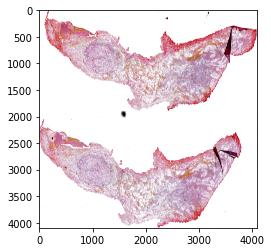

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:727: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:733: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:735: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


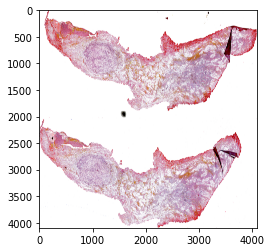

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Thuong/data574/image1_100/03d1ec_0.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
image = distort_image_with_randaugment(image, 3, 4, 'Default')
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
import os
root_dir = '/content/drive/MyDrive/Thuong/data574'
folders = os.listdir(root_dir)
folder_paths = [os.path.join(root_dir, folder) for folder in folders if os.path.isdir(os.path.join(root_dir, folder))]
folder_paths

['/content/drive/MyDrive/Thuong/data574/image1_100',
 '/content/drive/MyDrive/Thuong/data574/image2_100_200',
 '/content/drive/MyDrive/Thuong/data574/image3_200_273',
 '/content/drive/MyDrive/Thuong/data574/image4_274_350',
 '/content/drive/MyDrive/Thuong/data574/image5_350_400',
 '/content/drive/MyDrive/Thuong/data574/image6_400_500',
 '/content/drive/MyDrive/Thuong/data574/image7_575.zip (Unzipped Files)']

In [ ]:
%cd /content/drive/MyDrive/Tham/mayo_strip/data_4096

/content/drive/MyDrive/Tham/mayo_strip/data_4096


In [ ]:
!unzip /content/drive/MyDrive/Tri/data.zip 

In [ ]:
!rm -r /content/drive/MyDrive/Tham/mayo_strip/augment_4096/train 

In [ ]:
augmented_dir = '/content/drive/MyDrive/Tham/mayo_strip/augment_4096/test'
train_folder = '/content/drive/MyDrive/Tham/mayo_strip/data_4096/data/test'
img_names = os.listdir(train_folder)
for i, img_name in enumerate(img_names):
  print('{} / {}'.format(i, len(img_names)))
  path = os.path.join(train_folder, img_name)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  new_img_1 = distort_image_with_randaugment(img, 3, 4, 'Default')
  new_img_2 = distort_image_with_randaugment(img, 3, 4, 'Default')
  new_img_3 = distort_image_with_randaugment(img, 3, 4, 'Default')
  new_img_1 = cv2.cvtColor(new_img_1, cv2.COLOR_BGR2RGB)
  new_img_2 = cv2.cvtColor(new_img_2, cv2.COLOR_BGR2RGB)
  new_img_3 = cv2.cvtColor(new_img_3, cv2.COLOR_BGR2RGB)
  img_id = img_name[:-4]
  cv2.imwrite(os.path.join(augmented_dir, '{}_v1.png'.format(img_id)), new_img_1)
  cv2.imwrite(os.path.join(augmented_dir, '{}_v2.png'.format(img_id)), new_img_2)
  cv2.imwrite(os.path.join(augmented_dir, '{}_v3.png'.format(img_id)), new_img_3)

0 / 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:727: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:733: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:735: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


1 / 4
2 / 4
3 / 4
